In [1]:
# ! rm -r images images_test test_set train_set ResNet50_model train_set.zip

In [2]:
! unzip images.zip
! unzip images_test.zip

Archive:  images.zip
  inflating: images/494_Led Zeppelin II (Remaster).jpg  
  inflating: images/458_Houses of the Holy (Deluxe Edition).jpg  
  inflating: images/232_Legend Remixed.jpg  
  inflating: images/169_Led Zeppelin III (Remaster).jpg  
  inflating: images/222_Physical Graffiti (Deluxe Edition).jpg  
  inflating: images/271_Houses of the Holy (Remaster).jpg  
  inflating: images/243_Led Zeppelin IV (Deluxe Edition).jpg  
  inflating: images/60_Adios Bahamas.jpg  
  inflating: images/138_Led Zeppelin IV (Remaster).jpg  
  inflating: images/479_Presence (Remaster).jpg  
  inflating: images/175_The Song Remains the Same (Remaster).jpg  
  inflating: images/77_Physical Graffiti (Remaster).jpg  
  inflating: images/57_In Through the out Door (Remaster).jpg  
  inflating: images/365_Coda (Deluxe Edition).jpg  
  inflating: images/146_Presence (Deluxe Edition).jpg  
  inflating: images/227_Led Zeppelin III (Deluxe Edition).jpg  
  inflating: images/27_Exodus (Deluxe Edition).jpg  
 

In [3]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from google.colab import files

In [4]:
img_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

In [5]:
print(len(os.listdir('images/')))
for file in tqdm(os.listdir('images/')):
    img = cv2.imread(os.path.join('images/', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in img_gen.flow(img, batch_size=1, save_to_dir='images/', save_prefix=file.split('.')[0], save_format='jpeg'):
        i += 1
        if i >= 39:
            break
print(f"\n{len(os.listdir('images/'))}")

500


100%|██████████| 500/500 [31:30<00:00,  3.78s/it]

19972


In [6]:
os.makedirs('train_set/', exist_ok=True)
os.makedirs('test_set/test', exist_ok=True)

for filename in os.listdir('images'):
  target_directory = os.path.join('train_set/', filename[0:filename.find('_')])
  os.makedirs(target_directory, exist_ok=True)
  image_path = os.path.join('images/', filename)
  shutil.move(image_path, target_directory)

for filename in os.listdir('images_test'):
  shutil.move(os.path.join('images_test/', filename), 'test_set/test')

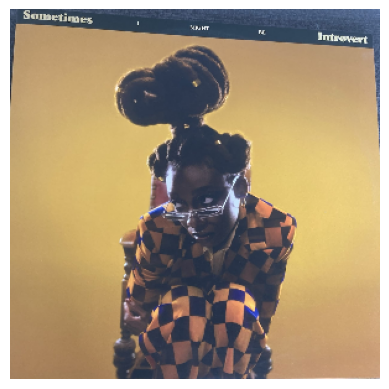

In [7]:
img = cv2.imread('test_set/test/121_Screenshot 2024-02-23 at 11.27.29.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (299, 299))
plt.imshow(img)
plt.axis('off')
plt.show()

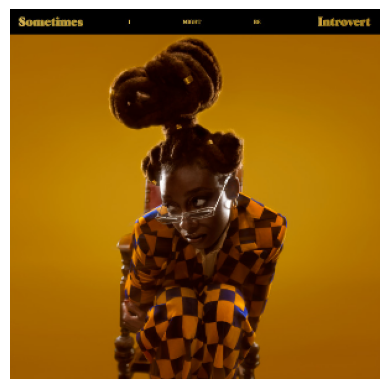

In [8]:
img = cv2.imread('train_set/121/121_Sometimes I Might Be Introvert.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (299, 299))
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
train_img_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_gen = train_img_gen.flow_from_directory('train_set/', target_size=(299, 299), batch_size=64, class_mode='categorical', subset='training')
val_data_gen = train_img_gen.flow_from_directory('train_set/', target_size=(299, 299), batch_size=64, class_mode='categorical', subset='validation')

Found 15998 images belonging to 500 classes.
Found 3974 images belonging to 500 classes.


In [21]:
inception_model = InceptionResNetV2(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=500
)

inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 149, 149, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 149, 149, 32)         0         ['batch_norm

In [22]:
inception_model.trainable = False
inception_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_406 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_406 (B  (None, 149, 149, 32)         96        ['conv2d_406[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_406 (Activation  (None, 149, 149, 32)         0         ['batch_norm

In [23]:
model = Sequential([inception_model, Dense(1024, activation='relu'), Dense(500, activation='softmax')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              1573888   
                                                                 
 dense_3 (Dense)             (None, 500)               512500    
                                                                 
Total params: 56423124 (215.24 MB)
Trainable params: 2086388 (7.96 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=20,
                    steps_per_epoch=len(train_data_gen),
                    validation_steps=len(val_data_gen),
                    callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 93s 329ms/step - loss: 1.3812 - accuracy: 0.8042 - val_loss: 0.1033 - val_accuracy: 0.9811
Epoch 2/20
250/250 [==============================] - 78s 311ms/step - loss: 0.0754 - accuracy: 0.9822 - val_loss: 0.0701 - val_accuracy: 0.9834
Epoch 3/20
250/250 [==============================] - 78s 311ms/step - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.0399 - val_accuracy: 0.9831
Epoch 4/20
250/250 [==============================] - 78s 312ms/step - loss: 0.0453 - accuracy: 0.9844 - val_loss: 0.0325 - val_accuracy: 0.9841
Epoch 5/20
250/250 [==============================] - 76s 306ms/step - loss: 0.0368 - accuracy: 0.9853 - val_loss: 0.0381 - val_accuracy: 0.9841
Epoch 6/20
250/250 [==============================] - 78s 311ms/step - loss: 0.0339 - accuracy: 0.9848 - val_loss: 0.0378 - val_accuracy: 0.9849
Epoch 7/20
250/250 [==============================] - 78s 313ms/step - loss: 0.0331 - accuracy: 0.9855 - val_loss: 0.0283 - val_ac

In [26]:
model.save('InceptionResNetV2_model')
print(os.listdir('InceptionResNetV2_model'))

['variables', 'keras_metadata.pb', 'assets', 'fingerprint.pb', 'saved_model.pb']


In [27]:
test_img_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = test_img_gen.flow_from_directory('test_set/', target_size=(224, 224), class_mode=None, shuffle=False)

Found 45 images belonging to 1 classes.


In [28]:
predictions = model.predict(test_data_gen)

2/2 [==============================] - 4s 214ms/step


In [29]:
predicted_labels = np.argmax(predictions, axis=1)
display(predicted_labels.shape)

true_labels = np.array([filename[5:filename.find('_')] for filename in test_data_gen.filenames])
true_labels = np.array( [train_data_gen.class_indices[x] for x in true_labels])
display(true_labels.shape)

print(f'The model accuracy score: {metrics.accuracy_score(true_labels, predicted_labels):.2f}')

(45,)

(45,)

The model accuracy score: 0.98


In [30]:
display(true_labels)
display(predicted_labels)

for filename, true_label, predicted_label in zip(test_data_gen.filenames, true_labels, predicted_labels):
    print(f"{filename}: {true_label} {predicted_label}")

array([ 25,  25,  25,  25,  25,  40,  40,  40,  40,  40,  80,  80,  80,
        80,  80, 110, 110, 110, 110, 110, 117, 117, 117, 117, 117, 201,
       201, 201, 201, 201, 224, 224, 224, 224, 224, 396, 396, 396, 396,
       396, 487, 487, 487, 487, 487])

array([ 25,  25,  25,  25,  25,  40,  40,  40,  40,  40,  80, 213,  80,
        80,  80, 110, 110, 110, 110, 110, 117, 117, 117, 117, 117, 201,
       201, 201, 201, 201, 224, 224, 224, 224, 224, 396, 396, 396, 396,
       396, 487, 487, 487, 487, 487])

test/121_Screenshot 2024-02-23 at 11.27.29.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.34.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.39.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.45.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.52.jpg: 25 25
test/135_Screenshot 2024-02-21 at 19.06.59.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.05.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.10.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.15.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.21.jpg: 40 40
test/171_Screenshot 2024-02-23 at 11.28.13.jpg: 80 80
test/171_Screenshot 2024-02-23 at 11.28.20.jpg: 80 213
test/171_Screenshot 2024-02-23 at 11.28.51.jpg: 80 80
test/171_Screenshot 2024-02-23 at 11.29.00.jpg: 80 80
test/171_Screenshot 2024-02-23 at 11.29.08.jpg: 80 80
test/199_Screenshot 2024-02-23 at 11.25.43.jpg: 110 110
test/199_Screenshot 2024-02-23 at 11.25.47.jpg: 110 110
test/199_Screenshot 2024-02-23 at 11.25.53.jpg: 110 110
test/199_Screenshot 2

In [32]:
! zip -r InceptionResNetV2_model.zip InceptionResNetV2_model

  adding: InceptionResNetV2_model/ (stored 0%)
  adding: InceptionResNetV2_model/variables/ (stored 0%)
  adding: InceptionResNetV2_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: InceptionResNetV2_model/variables/variables.index (deflated 78%)
  adding: InceptionResNetV2_model/keras_metadata.pb (deflated 96%)
  adding: InceptionResNetV2_model/assets/ (stored 0%)
  adding: InceptionResNetV2_model/fingerprint.pb (stored 0%)
  adding: InceptionResNetV2_model/saved_model.pb (deflated 92%)


In [33]:
files.download('InceptionResNetV2_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>